<a href="https://colab.research.google.com/github/SalimuKabogere/XAI/blob/main/LIME_KD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=309e20e9ae8ce3404a4f5c567f92def0eb112e80b43167edfcc579efbc010d14
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import torch
import numpy as np
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = "/content/drive/My Drive/Dataset4"

# Verify dataset structure
os.listdir(dataset_path)

Mounted at /content/drive


['Testing', 'Validation', 'Training', 'testing', 'processed', 'raw']

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define CNN Student Model (MUST match the original architecture)
class CNNStudent(nn.Module):
    def __init__(self):
        super(CNNStudent, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  # Initialize with expected size
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Reshape using contiguous() before view
        x = x.contiguous().view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_student = CNNStudent().to(device)

# Load saved model weights
model_save_path = "/content/drive/My Drive/kd_fake_currency_model.pth"
cnn_student.load_state_dict(torch.load(model_save_path, map_location=device))
cnn_student.eval()

print("Model Loaded Successfully!")

Model Loaded Successfully!


In [13]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import torch
import torch.nn.functional as F

In [14]:
# Define sample image path
sample_image_path = "/content/drive/MyDrive/Dataset4/Training/Real/12.jpg"

# Define transformations (resize to match model input size)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust if different input size
    transforms.ToTensor(),
])

# Load and preprocess the image
image = Image.open(sample_image_path).convert("RGB")
image = transform(image)  # Apply transformations
image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)

# Convert to NumPy format for LIME
test_image = image.squeeze(0).permute(1, 2, 0).numpy()


  0%|          | 0/1000 [00:00<?, ?it/s]

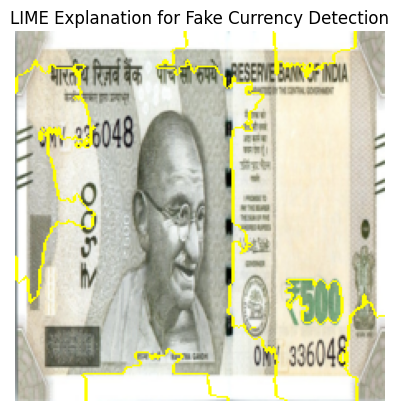

In [15]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Define LIME Explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict using the loaded KD model
def predict_fn(images):
    # Convert image from (batch, H, W, C) to (batch, C, H, W)
    images = torch.tensor(images.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)

    # Get model predictions
    outputs = cnn_student(images)

    # Apply softmax for probability distribution
    return F.softmax(outputs, dim=1).detach().cpu().numpy()

# Apply LIME explanation
explanation = explainer.explain_instance(
    test_image,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000  # Higher = more accurate
)

# Get explanation mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Visualize the result
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation for Fake Currency Detection")
plt.show()
